LOADED RESULTS
Parameters:
  K: 4
  L: 64
  D: 2
  N: 8
  B: 1
  n_nodes: 8
  epochs: 1000
  lr: 0.0025
  batch_size: 64
  train_samples: 100000
  val_samples: 2000
  epsilon: 0.001
  seed: 22
  exact_copy: True
  method: direct_solve
  temperature: 1.0
  shuffle_context: True
  learn_base_rates: False
  offset: 0.0
  min_max_choice: None
  unique_labels: False

Execution time: 3972.71 seconds

Test Results:
Available keys: ['in_dist', 'novel_classes']
  in_dist: 100.0000
  novel_classes: 36.2000


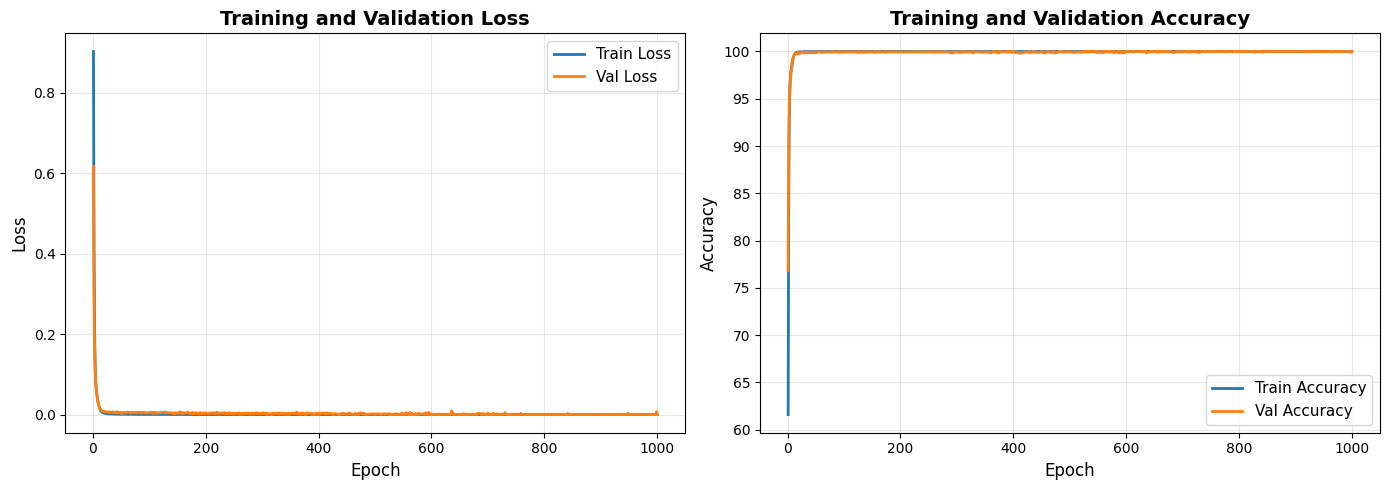


FINAL PERFORMANCE
Final Train Loss: 0.0004
Final Val Loss: 0.0001
Best Val Loss: 0.0000 (Epoch 869)
Final Train Accuracy: 99.9930
Final Val Accuracy: 100.0000
Best Val Accuracy: 100.0000 (Epoch 308)

ICL vs IWL ANALYSIS


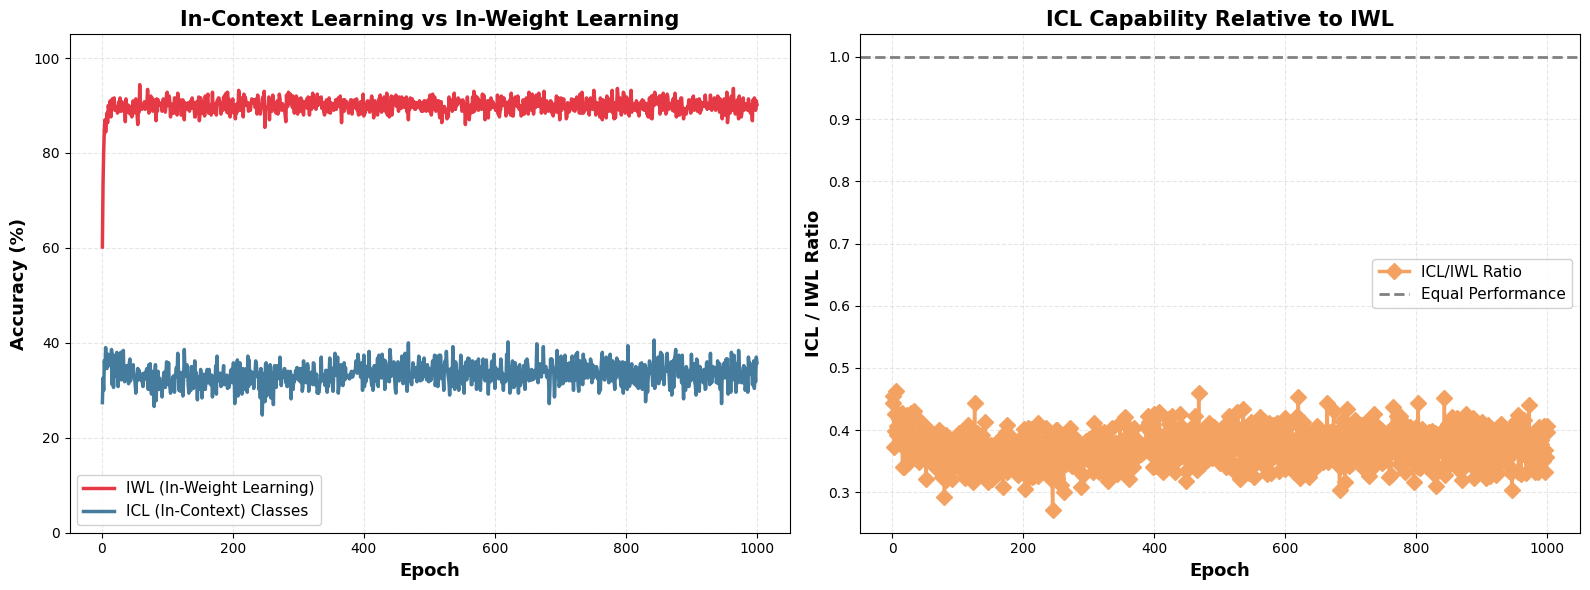


Final Accuracies:
  IWL (In-Weight):        90.20%
  ICL (In-Context) Classes:      35.80%

Best Accuracies:
  Best IWL:               94.40% (Epoch 58)
  Best ICL:         40.60% (Epoch 843)

Learning Mode Analysis:
  ⚠ STRONG IWL: Model primarily memorizes training distribution


In [9]:
# Import necessary components
import torch
import numpy as np

# Import from refactored modular structure
from data_generation import GaussianMixtureModel, generate_icl_gmm_data
from datasets import ICLGMMDataset, collate_fn
from models import MatrixTreeMarkovICL
from training import train_model
from evaluation import test_icl

from torch.utils.data import DataLoader
import os
import time

path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/n_nodes/5/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/lr/0.001/"
path = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/D_K/2_4/"


import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the results
results_path = path + "results.pkl"
with open(results_path, "rb") as file:
    data = pickle.load(file)

# Extract components
results = data['results']
history = data['history']
params = data['params']
execution_time = data['execution_time']

# Print parameters
print("="*70)
print("LOADED RESULTS")
print("="*70)
print(f"Parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")
print(f"\nExecution time: {execution_time:.2f} seconds")
print("="*70)

# Print test results (check what keys exist)
print("\nTest Results:")
print("Available keys:", list(results.keys()))
for key, value in results.items():
    if isinstance(value, (int, float)):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
ax1 = axes[0]
epochs_plot = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs_plot, history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(epochs_plot, history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy curves (if available)
ax2 = axes[1]
if 'train_acc' in history and 'val_acc' in history:
    ax2.plot(epochs_plot, history['train_acc'], label='Train Accuracy', linewidth=2)
    ax2.plot(epochs_plot, history['val_acc'], label='Val Accuracy', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
else:
    # If no accuracy, plot loss on log scale
    ax2.semilogy(epochs_plot, history['train_loss'], label='Train Loss', linewidth=2)
    ax2.semilogy(epochs_plot, history['val_loss'], label='Val Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss (log scale)', fontsize=12)
    ax2.set_title('Training and Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print final performance
print("\n" + "="*70)
print("FINAL PERFORMANCE")
print("="*70)
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
print(f"Best Val Loss: {min(history['val_loss']):.4f} (Epoch {np.argmin(history['val_loss'])+1})")
if 'train_acc' in history:
    print(f"Final Train Accuracy: {history['train_acc'][-1]:.4f}")
    print(f"Final Val Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"Best Val Accuracy: {max(history['val_acc']):.4f} (Epoch {np.argmax(history['val_acc'])+1})")
print("="*70)

# ========================================================================
# Plot ICL vs IWL Metrics
# ========================================================================

# Check if ICL/IWL metrics are available
if 'iwl_acc' in history and any(v is not None for v in history['iwl_acc']):
    print("\n" + "="*70)
    print("ICL vs IWL ANALYSIS")
    print("="*70)
    
    # Extract ICL/IWL metrics (filter out None values)
    epochs_eval = [i+1 for i, val in enumerate(history['iwl_acc']) if val is not None]
    iwl_acc = [val for val in history['iwl_acc'] if val is not None]
    icl_acc = [val for val in history['icl_acc'] if val is not None]
   
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: All three metrics over time
    ax1 = axes[0]
    ax1.plot(epochs_eval, iwl_acc, label='IWL (In-Weight Learning)', 
             linewidth=2.5, color='#E63946')
    ax1.plot(epochs_eval, icl_acc, label='ICL (In-Context) Classes', 
             linewidth=2.5, color='#457B9D')
    ax1.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax1.set_title('In-Context Learning vs In-Weight Learning', fontsize=15, fontweight='bold')
    ax1.legend(fontsize=11, loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim([0, 105])
    
    # Plot 2: ICL/IWL Ratio (ICL capability relative to IWL)
    ax2 = axes[1]
    # Calculate ratio: ICL_novel / IWL (higher means more ICL capability)
    icl_iwl_ratio = [icl / max(iwl, 1e-6) for icl, iwl in zip(icl_acc, iwl_acc)]
    ax2.plot(epochs_eval, icl_iwl_ratio, 'D-', label='ICL/IWL Ratio', 
             linewidth=2.5, markersize=8, color='#F4A261')
    ax2.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, label='Equal Performance')
    ax2.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax2.set_ylabel('ICL / IWL Ratio', fontsize=13, fontweight='bold')
    ax2.set_title('ICL Capability Relative to IWL', fontsize=15, fontweight='bold')
    ax2.legend(fontsize=11, loc='best', framealpha=0.9)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nFinal Accuracies:")
    print(f"  IWL (In-Weight):        {iwl_acc[-1]:.2f}%")
    print(f"  ICL (In-Context) Classes:      {icl_acc[-1]:.2f}%")
  
    
    print("\nBest Accuracies:")
    print(f"  Best IWL:               {max(iwl_acc):.2f}% (Epoch {epochs_eval[np.argmax(iwl_acc)]})")
    print(f"  Best ICL:         {max(icl_acc):.2f}% (Epoch {epochs_eval[np.argmax(icl_acc)]})")
   
    
    print("\nLearning Mode Analysis:")
    final_iwl = iwl_acc[-1]
    final_icl = icl_acc[-1]
    
    if final_icl > 80 and final_iwl < 50:
        print("  ✓ STRONG ICL: Model primarily uses in-context learning")
    elif final_iwl > 80 and final_icl < 50:
        print("  ⚠ STRONG IWL: Model primarily memorizes training distribution")
    elif final_icl > 70 and final_iwl > 70:
        print("  ✓ HYBRID: Model can do both ICL and IWL")
    elif final_icl > final_iwl + 20:
        print("  ✓ ICL-DOMINANT: Model prefers in-context learning")
    elif final_iwl > final_icl + 20:
        print("  ⚠ IWL-DOMINANT: Model prefers memorization")
    else:
        print("  ○ BALANCED: Similar ICL and IWL performance")
    
    print("="*70)
    
else:
    print("\n⚠ No ICL/IWL metrics found in history.")
    print("  These metrics were likely not tracked during training.")
    print("  Run training with the updated train_model function to track ICL/IWL.")


In [39]:
8148/3600

2.263333333333333

In [34]:
15**2

225

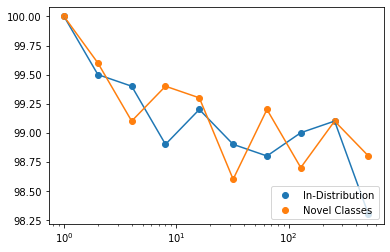

In [35]:
var_list = [5, 10, 15, 20]
var_list = [5, 10, 15, 20, 25, 30]
var_list = [4, 6, 8, 10, 12]
in_dist_list = []
novel_classes_list = []

var_list = 2**np.arange(0,10,1)
path_base = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/L/"

for var in var_list:
    path = path_base + str(var) + "/"
    results_path = path + "results.pkl"
    with open(results_path, "rb") as file:
        data = pickle.load(file)
    results = data['results']
    in_dist_list.append(results['in_dist'])
    novel_classes_list.append(results['novel_classes'])

plt.scatter(var_list, in_dist_list, label='In-Distribution')
plt.scatter(var_list, novel_classes_list, label='Novel Classes')
plt.plot(var_list, in_dist_list)
plt.plot(var_list, novel_classes_list)
plt.xscale('log')
#plt.ylim(0, 101)
plt.legend(loc='lower right')
plt.show()




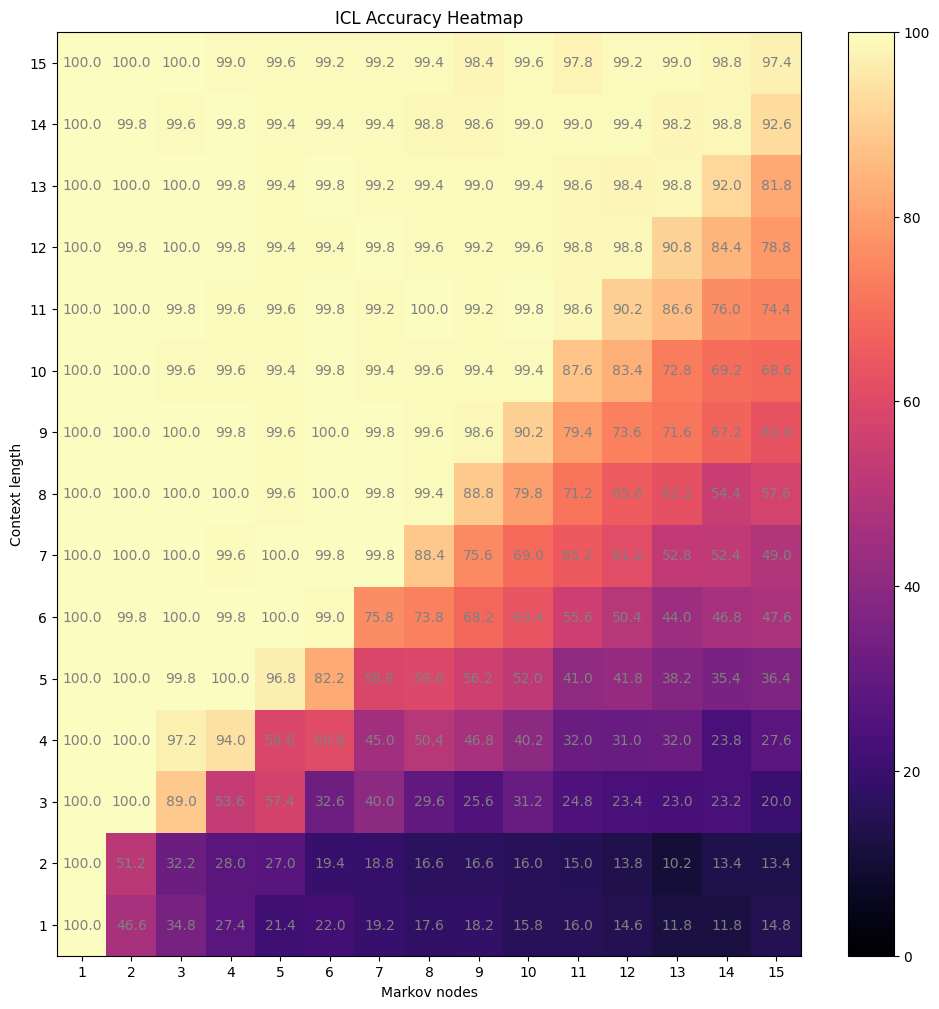

In [16]:
param1_values = [2,4]
param2_values = 2**np.array([4,6,8,10])
path_base = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/B_K/"

param1_values = [2,3,4,5,6,7,8,9,10]
param2_values = [2,3,4,5,6,7,8,9,10]
param1_values = np.arange(1,16,1)
param2_values = np.arange(1,16,1)
path_base = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/N_n_nodes_verybig2/"


# param1_values = 2**np.arange(0,8,1)
# param2_values = 2**np.arange(0,11,2)
# path_base = "/Users/csfloyd/Dropbox/Projects/MarkovComputation/DirsICL/D_K/"


results_grid = np.zeros((len(param1_values), len(param2_values)))
for i, param1 in enumerate(param1_values):
    for j, param2 in enumerate(param2_values):
        path = path_base + str(param1) + "_" + str(param2) + "/"
        results_path = path + "results.pkl"
        with open(results_path, "rb") as file:
            data = pickle.load(file)
        results = data['results']
        history = data['history']
        icl_acc = [val for val in history['icl_acc'] if val is not None]
        results_grid[i, j] = icl_acc[-1]
        #results_grid[i, j] = results['in_dist']
        #results_grid[i, j] = history['train_acc'][-1]


# plot
fig, ax = plt.subplots(figsize=(12, 12))

im = ax.imshow(results_grid.T, cmap='magma', aspect='auto', origin='lower', vmin = 0, vmax = 100)
plt.colorbar(im, ax=ax)
ax.set_xlabel('Markov nodes')
ax.set_ylabel('Context length')
# ax.set_xlabel('D')
# ax.set_ylabel('K')
ax.set_yticks(range(len(param2_values)), param2_values)
ax.set_xticks(range(len(param1_values)), param1_values)
ax.set_title('ICL Accuracy Heatmap')

# Add text annotations for each cell
for i in range(len(param1_values)):
    for j in range(len(param2_values)):
        text = ax.text(i, j, f'{results_grid[i, j]:.1f}',
                       ha="center", va="center", color="gray", fontsize=10)

plt.show()


In [30]:
(8*8)*9*128 + 8*8

73792

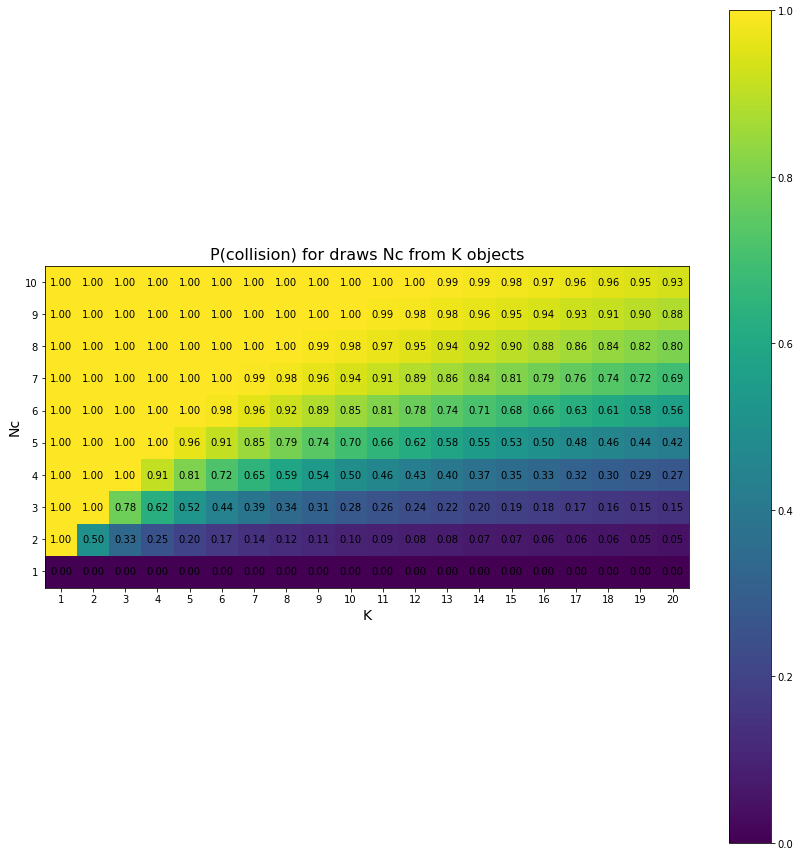

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def p_collision_exact(K, Nc):
    """Probability of at least one collision when drawing Nc times from K objects."""
    if Nc > K:
        return 1.0
    p_no = 1.0
    for i in range(Nc):
        p_no *= (K - i) / K
    return 1.0 - p_no

# ranges
max_K = 20
max_Nc = 10

# table[Nc-1, K-1] = p(collision)
table = np.zeros((max_Nc, max_K))
for Nc in range(1, max_Nc+1):
    for K in range(1, max_K+1):
        table[Nc-1, K-1] = p_collision_exact(K, Nc)

# plot
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(table, origin='lower')

# write numbers on each pixel
for i in range(max_Nc):
    for j in range(max_K):
        ax.text(j, i, f"{table[i, j]:.2f}", ha="center", va="center")

# axis labels and ticks
ax.set_xlabel("K", fontsize=14)
ax.set_ylabel("Nc", fontsize=14)
ax.set_xticks(range(max_K))
ax.set_xticklabels(range(1, max_K+1))
ax.set_yticks(range(max_Nc))
ax.set_yticklabels(range(1, max_Nc+1))

plt.title("P(collision) for draws Nc from K objects", fontsize=16)
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


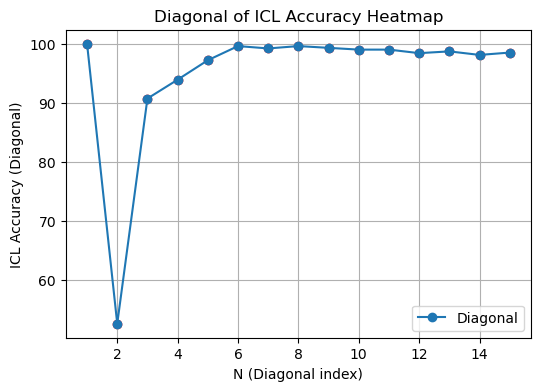

In [36]:
# Plot diagonal of results_grid as scatter and lines
diagonal = np.diag(results_grid)
plt.figure(figsize=(6,4))
plt.plot(param1_values[:len(diagonal)], diagonal, marker='o', linestyle='-', label='Diagonal')
plt.scatter(param1_values[:len(diagonal)], diagonal, color='red')
plt.xlabel('N (Diagonal index)')
plt.ylabel('ICL Accuracy (Diagonal)')
plt.title('Diagonal of ICL Accuracy Heatmap')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
results_grid

array([[97.6, 97.8, 96.8],
       [90.2, 95.8, 96.9],
       [85.5, 91.1, 94.9]])

In [10]:
results_grid[0,-1]

24.2

In [15]:
import math
n = 15*14
k = 7
math.comb(n, k)

3230129794320